In [46]:
!pip install kaggle

In [47]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [48]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
import json
token = {"username":"","key":""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [51]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [1]:
!kaggle datasets list -s amazon

### METHOD 1
This is one of the method to directly download the data from kaggle

In [2]:
!kaggle competitions download -c snap/amazon-fine-food-reviews

### METHOD 2
Another way to mount the google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
!ls /content/drive/My\ Drive/amazon_data/amazon-fine-food-reviews/

database.sqlite  hashes.txt  Reviews.csv


### METHOD 3
Upload the files directly to colab so that data can be accessed quickly

In [59]:
# So we use method 3 to proceed
!ls

amazon_data.zip  drive	sample_data


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("amazon_data.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [66]:
!ls amazon/amazon_data/amazon-fine-food-reviews/

database.sqlite  hashes.txt  Reviews.csv


In [0]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

In [70]:
!pwd

/content


In [72]:
!ls

amazon	amazon_data.zip  drive	sample_data


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon/amazon_data/amazon-fine-food-reviews/database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [75]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [77]:
final.shape

(4986, 10)

In [0]:
from bs4 import BeautifulSoup

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [81]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3566.58it/s]


In [82]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 4986/4986 [00:00<00:00, 5009.36it/s]


In [83]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

Using TensorFlow backend.


In [0]:
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [0]:
# config
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 4986
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [0]:
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# Adding <sos> & <eos> to preprocessed_summary
# target_texts --> With <eos>
# target_texts_inputs --> With <sos>

for i in preprocessed_summary:
    target_text = i + ' <eos>'
    target_text_input = '<sos> ' + i
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)

In [0]:
input_texts = preprocessed_reviews.copy()

In [88]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 13015 unique input tokens.


In [0]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

In [90]:
# As explained below
### input_sequences 
# --> Length 4986 means 4986 sentences
# --> Each sentences represents in numerical format using tokenizer with variable length

### word2idx_inputs
# --> It is dictionary with key as word and value as numerical unique representation

print(type(tokenizer_inputs))
print(type(input_sequences))
print(len(input_sequences))
print(len(input_sequences[2]))
print((input_sequences[0]))
print(list(word2idx_inputs.items())[5])
print(list(word2idx_inputs.items())[7])

<class 'keras_preprocessing.text.Tokenizer'>
<class 'list'>
4986
39
[7, 240, 5417, 5418, 5419, 414, 1147, 3818, 7211, 144, 2418, 86, 1898]
('one', 6)
('would', 8)


In [91]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear

tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


Found 2971 unique output tokens.


In [92]:

print('='* 120)
# tokenizer_outputs
# --> It is tokenizer use to convert word to unique numerical value
print(type(tokenizer_outputs))
print('='* 120)

print('# target_sequences')
print('# --> It is sequences with <eos>')
print('# --> Length 4986 as total sentences are 4986')
print('# --> Each sentences is of different length')
print(type(target_sequences))
print(len(target_sequences))
print(len(target_sequences[20]))
print((target_sequences[20]))
print('='* 120)

print('# target_sequences_inputs')
print('# --> It have sequences with <sos>')
print('# --> Length 4986 as total sentences are 4986')
print('# --> Each sentences is of different length')
print(type(target_sequences_inputs))
print(len(target_sequences_inputs))
print(len(target_sequences_inputs[20]))
print((target_sequences_inputs[20]))
print('='* 120)

print('# word2idx_outputs')
print('# --> It is Dictionary with key word and value as unique numeric value')
print(type(word2idx_outputs))
print(list(word2idx_outputs.items())[0])
print(list(word2idx_outputs.items())[1])
print(list(word2idx_outputs.items())[2])
print('='* 120)

<class 'keras_preprocessing.text.Tokenizer'>
# target_sequences
# --> It is sequences with <eos>
# --> Length 4986 as total sentences are 4986
# --> Each sentences is of different length
<class 'list'>
4986
5
[1317, 1318, 157, 1319, 1]
# target_sequences_inputs
# --> It have sequences with <sos>
# --> Length 4986 as total sentences are 4986
# --> Each sentences is of different length
<class 'list'>
4986
5
[2, 1317, 1318, 157, 1319]
# word2idx_outputs
# --> It is Dictionary with key word and value as unique numeric value
<class 'dict'>
('<eos>', 1)
('<sos>', 2)
('great', 3)


In [93]:
# pad the sequences
# According to max len padding the sequences
print('='* 120)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print(type(decoder_inputs))
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)
print('='* 120)


decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print(type(decoder_targets))
print("decoder_targets[0]:", decoder_targets[0])
print("decoder_targets.shape:", decoder_targets.shape)
print('='* 120)

encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print(type(encoder_inputs))
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])
print('='* 120)



<class 'numpy.ndarray'>
decoder_data[0]: [   2 1309 1310    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
decoder_data.shape: (4986, 20)
<class 'numpy.ndarray'>
decoder_targets[0]: [1309 1310    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
decoder_targets.shape: (4986, 20)
<class 'numpy.ndarray'>
encoder_data.shape: (4986, 486)
encoder_data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   

In [95]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("amazon/amazon_data/glove/glove.6B.100d.txt", encoding='utf8', errors = 'ignore') as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [96]:
print('prepare embedding matrix')
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

prepare embedding matrix
Filling pre-trained embeddings...


In [0]:
# create embedding layer
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_len_input)

In [0]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_target,num_words_output),dtype='float32')

# assign the values
for i, d in enumerate(decoder_targets):
    # Here d is sentence and i is index
    # example [1309 1310    1    0    0    0    0    0    0    0    0    0    0    0   0    0    0    0    0    0]
    for t, word in enumerate(d):
        # Here t is index of each word in d and word is unique numeric value
        # if d is --> [1309 1310    1    0    0    0    0    0    0    0    0    0    0    0   0    0    0    0    0    0]
        # then t is 0 --> 1309 is word
        # then t is 1 --> 1310 is word
        decoder_targets_one_hot[i, t, word] = 1

In [99]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [100]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3772644434745736421
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2266911202489989997
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16162767323491671642
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6687883656335654878
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
##### build the model #####

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM( LATENT_DIM, return_sequences=True,dropout=0.5,))
encoder_outputs = encoder(x)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [0]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
    # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
    # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
    # copy s(t-1) Tx times
    # now shape = (Tx, LATENT_DIM_DECODER)
    st_1 = attn_repeat_layer(st_1)
    # Concatenate all h(t)'s with s(t-1)
    # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    x = attn_concat_layer([h, st_1])
    # Neural net first layer
    x = attn_dense1(x)
    # Neural net second layer with special softmax over time
    alphas = attn_dense2(x)
    # "Dot" the alphas and the h's
    # Remember a.dot(b) = sum over a[t] * b[t]
    context = attn_dot([alphas, h])
    return context

In [0]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True,dropout=0.5)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [0]:
# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
    # get the context using attention
    context = one_step_attention(encoder_outputs, s)
    # we need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)
    # combine 
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)


In [0]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size x output_vocab_size tensor
    x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
    x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
    return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [0]:
final_weights_path = 'best_modelAmazon.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),TensorBoard(log_dir='Graph', histogram_freq=1, write_graph=True, write_images=True)
]

In [4]:
#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [0]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

In [110]:
# compile the model
model.compile(optimizer="rmsprop", loss='categorical_crossentropy')

# train the model
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=64,
  epochs=EPOCHS,
  validation_split=0.2,callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3988 samples, validate on 998 samples
Epoch 1/100
 128/3988 [..............................] - ETA: 7:14 - loss: 7.9326 

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.688329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3988/3988 [==============================] - 141s 35ms/step - loss: 1.6359 - val_loss: 1.2131

Epoch 00001: val_loss improved from inf to 1.21313, saving model to best_modelAmazon.h5
Epoch 2/100
3988/3988 [==============================] - 128s 32ms/step - loss: 1.1437 - val_loss: 1.1389

Epoch 00002: val_loss improved from 1.21313 to 1.13894, saving model to best_modelAmazon.h5
Epoch 3/100
3988/3988 [==============================] - 127s 32ms/step - loss: 1.0449 - val_loss: 1.1226

Epoch 00003: val_loss improved from 1.13894 to 1.12264, saving model to best_modelAmazon.h5
Epoch 4/100
3988/3988 [==============================] - 127s 32ms/step - loss: 1.0202 - val_loss: 1.1399

Epoch 00004: val_loss did not improve from 1.12264
Epoch 5/100
3988/3988 [==============================] - 128s 32ms/step - loss: 1.0037 - val_loss: 1.1361

Epoch 00005: val_loss did not improve from 1.12264
Epoch 6/100
3988/3988 [==============================] - 126s 32ms/step - loss: 0.9916 - val_loss: 1.10

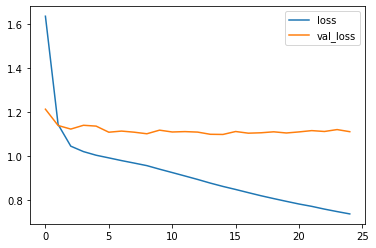

In [111]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [0]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D



# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


In [0]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_out = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']
    
    # if we get this we break
    eos = word2idx_outputs['<eos>']
    # [s, c] will be updated in each loop iteration
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))
    
    # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        # Get next word
        idx = np.argmax(o.flatten())
        # End sentence of EOS
        if eos == idx:
            break
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx
    return ' '.join(output_sentence)

In [116]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
Input sentence: erin baker products fruit nut mini breakfast cookie favorite one mini breakfast cookie calories cup coffee morning feel satisfied ready start day healthy low caloreis super delicious makes product work try like
Predicted translation: best coffee ever
Actual translation: healthy breakfast lover <eos>
Continue? [Y/n]y
-
Input sentence: item great price tastes great thing could make product better little plastic cup recyclable compostable
Predicted translation: great product
Actual translation: grandkids love <eos>
Continue? [Y/n]y
-
Input sentence: erin baker products favorite family breakfast cookie mini great snacks coffee breaks especially good traveling denser product regular cookie nice chewy filling calories
Predicted translation: great waffle mix
Actual translation: breakfast cookies <eos>
Continue? [Y/n]y
-
Input sentence: not work windows tried reinstating software no surprise di not work waste time money aware issue
Predicted translation: not work
Actual trans